This notebook uses matrix-based entropy [1, 2, 3] to analyze the "mutual information plane" of pretrained LLMs. 

Great matrix entropy theorethical formulation provided by Oscar Skean!

## The Matrix-based Entropy Quantity


Matrix-based entropy was first proposed in [1]. It is a quantity which serves as a tractable surrogate for traditional Shannon's entropy. It's calculated using a kernel $\kappa$ on a batch of samples drawn from a distribution, without making explicit assumptions on what the true distribution is. Before introducing matrix-based entropy, it would be helpful to introduce its traditional information theory analogue called Renyi entropy, given by:

\begin{equation}
\tag{Renyi Entropy}
H_{\alpha}({P}) = \frac{1}{1-\alpha}\log{\sum_{i-1}^n p_i^{\alpha}}
\end{equation}

The Renyi entropy is a family of entropies parameterized by $\alpha$. Notable special cases are $\alpha=0$ (max-entropy), $\displaystyle \lim_{\alpha \rightarrow 1}$ (Shannon entropy), and $\alpha=2$ (collision entropy). A good writeup of Renyi entropy and the usecases of different choices of $\alpha$ is given in [4].

The definition of matrix-based entropy is given as follows.
Given a infinitely divisible kernel $\kappa$, we first construct a Gram matrix $\mathbf{K}_{\mathbf{X}} \in \mathbb{R}^{\textrm{N} \times \textrm{N}}$ consisting of all pairwise evaluations of the $N$ points in $\mathbf{X}$. The choice of $\kappa$ can be fairly flexible and could be a Gaussian kernel, linear kernel, Laplacian kernel, etc. Given $\mathbf{K}_{\mathbf{X}}$, the matrix-based entropy of order $\alpha>0$ is defined as:
\begin{equation}
\tag{Matrix-based Entropy}
S_{\alpha}\left(\mathbf{K}_{\mathbf{X}}\right) = \frac{1}{1-\alpha}\log{\left[\textrm{tr}{\left( \left( \frac{\mathbf{K}_{\mathbf{X}}}{\textrm{tr}(\mathbf{K}_{\mathbf{X}})} \right)^{\alpha}\right) }\right]},
\end{equation}

 Raising a matrix to the power of an arbitary real-valued $\alpha$ is in general difficult, so using the fact that $tr(A) = \sum_{i=1}^n \lambda_i(A)$ we can equivalently compute the above as:

\begin{equation}
\tag{Matrix-based Entropy}
S_{\alpha}\left(\mathbf{K}_{\mathbf{X}}\right) = \frac{1}{1-\alpha}\log{\left[ \sum_{i=1}^N \frac{\lambda_i(\mathbf{K}_{\mathbf{X}})}{\textrm{tr}(\mathbf{K}_{\mathbf{X}})} \right]},
\end{equation}

Notice how the matrix $\mathbf{K}_{\mathbf{X}}$ is normalized before being raised to the $\alpha$ power. This is so that the eigenvalues of $\mathbf{K}_{\mathbf{X}}$ all sum to one (as per $tr(A) = \sum_{i=1}^n \lambda_i(A)$), which is a necessary condition to treat the eigenvalues as a probability distribution. The eigenvalues of $\mathbf{K}_{\mathbf{X}}$ signify the variance of datapoints in a particular principal component direction. Therefore Equation 3 is reminescent to the so called $logdet$ entropy which captures how much "volume" a dataset occupies. However, there are many hyperparameters involved in the logdet computation to improve stability and, in my experience, the above equation is much more stable.

Like Shannon's entropy, the matrix-based entropy acts as a building block for more complex quantites such as joint entropy and mutual information. The definitions for several important matrix-based quantities are given below. Note that $\kappa$ can be any infinitely divisible kernel or corresponding covariance matrix. The following definitions are rigously introduced in [1] and gently summarized in [2].

### Matrix-based joint entropy
In the following, the $\circ$ operation is the Hadamard product aka elementwise product.
\begin{equation}
\tag{Joint Entropy}
S_{\alpha}\left(\mathbf{K}_{\mathbf{X}}, \mathbf{K}_{\mathbf{Y}} \right) = S_{\alpha}(\mathbf{K}_\mathbf{X} \circ \mathbf{K}_\mathbf{Y})
\end{equation}

### Matrix-based conditional entropy

\begin{equation}
\tag{Conditional Entropy}
S_{\alpha}(\mathbf{K}_\mathbf{X} \vert \mathbf{K}_\mathbf{Y}) = S_{\alpha}(\mathbf{K}_\mathbf{X} \circ \mathbf{K}_\mathbf{Y}) - S_{\alpha}(\mathbf{K}_\mathbf{Y}). 
\end{equation}

### Matrix-based mutual information

\begin{equation}
\tag{Mutual Information}
I_{\alpha}(\mathbf{K}_\mathbf{X} ; \mathbf{K}_\mathbf{Y}) =  S_{\alpha}(\mathbf{K}_\mathbf{X}) - S_{\alpha}(\mathbf{K}_\mathbf{X} \vert \mathbf{K}_\mathbf{Y}) = S_{\alpha}(\mathbf{K}_\mathbf{X}) +  S_{\alpha}(\mathbf{K}_\mathbf{Y}) - S_{\alpha}(\mathbf{K}_\mathbf{X} \circ \mathbf{K}_\mathbf{Y}), 
\end{equation}

## Random Interesting Properties

1. If $\alpha=2$, you can avoid explicit eigendecomposition with the Frobenius norm $||A||_F^2 = \sum_{i} \sum_{j} A_{ij}^2 = \sum_i^n \lambda_i(A)^2$. The $O(n^3)$ eigendecomposition on the rhs is reduced to a $O(n^2)$ sum of matrix elements in the middle. This property was exploited in the field of self-supervised learning in [6].

2. It must be emphasized the matrix-based entropy is NOT necessarily an estimator of Shannon's entropy of the data. It is a different measure of entropy that satisfies the axioms of entropy proposed by Renyi. However, it has been shown that if $\kappa$ is a Gaussian kernel with bandwidth $\sigma$, then as batch size $N \rightarrow \infty$ and $\sigma \rightarrow 0$, then matrix-based entropy is equal to Shannon's entropy. Loosely speaking, this follows from Parzen density estimation principles where the kernel evaluation is equal to the probability of a sample under these limit conditions.

## References

1. Giraldo, Luis Gonzalo Sanchez, Murali Rao, and Jose C. Principe. "Measures of entropy from data using infinitely divisible kernels.
2. Skean, Oscar, et al. "Dime: Maximizing mutual information by a difference of matrix-based entropies. 
3. Bach, Francis. "Information theory with kernel methods."
4. https://en.wikipedia.org/wiki/R%C3%A9nyi_entropy
5. Wei, et al. "Large Language Model Evaluation via Matrix Entropy"
6. Skean, Oscar, et al. "FroSSL: Frobenius Norm Minimization for
Efficient Multiview Self-Supervised Learning"

# Entropy of Dataset

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import os
from pathlib import Path
from collections import defaultdict


entropies_dir = Path("../data/entropies/wikitext")
entropies = defaultdict(dict)

for entropy_file in entropies_dir.rglob("*.json"):
    model = entropy_file.parent.name
    # if "opt" not in model:
    #     continue
    with open(entropy_file, "r") as f:
        entropies[model][entropy_file.stem] = json.load(f)

In [4]:
len(entropies)

17

# Plot entropies histogram

In [6]:
from plots import plot_all_entropies

# model_sizes = ['EleutherAI_pythia-1b', 'EleutherAI_pythia-1.4b', 'EleutherAI_pythia-2.8b', 'EleutherAI_pythia-6.9b', 'EleutherAI_pythia-12b']
model_sizes = ['facebook_opt-1.3b', 'facebook_opt-2.7b', 'facebook_opt-6.7b', 'facebook_opt-13b']

# plot_all_entropies(entropies=entropies, model_sizes=model_sizes, hidden_state="last", framework="gptq", allow_2bit=True)


# Plot avg. entropies per model size and quantization

In [11]:
from plots import get_metric

def get_entropy(entropies, model_size, quantization, hidden_state, metric):
    model_entropies = entropies.get(model_size, None)
    if model_entropies is not None:
        model_quantized_entropies = model_entropies.get(quantization, None)
        if model_quantized_entropies is not None:
            return get_metric(model_quantized_entropies, metric, hidden_state)
    return None

In [35]:
entropies.keys()

dict_keys(['EleutherAI_pythia-14m', 'EleutherAI_pythia-70m', 'EleutherAI_pythia-160m', 'EleutherAI_pythia-410m', 'EleutherAI_pythia-1b', 'EleutherAI_pythia-1.4b', 'EleutherAI_pythia-2.8b', 'facebook_opt-350m', 'facebook_opt-1.3b', 'facebook_opt-125m', 'facebook_opt-6.7b', 'facebook_opt-2.7b', 'facebook_opt-13b', 'huggyllama_llama-13b', 'huggyllama_llama-7b', 'EleutherAI_pythia-12b', 'EleutherAI_pythia-6.9b'])

In [36]:
import re
import numpy as np
from plots import get_metric

hidden_state = "last"
metrics = ["logD_normalized_entropy"]
model_sizes = [
    'EleutherAI_pythia-1.4b', 'EleutherAI_pythia-2.8b', 'EleutherAI_pythia-6.9b', 'EleutherAI_pythia-12b', 
    'facebook_opt-1.3b', 'facebook_opt-2.7b', 'facebook_opt-6.7b', 'facebook_opt-13b'] #, 'huggyllama_llama-7b', 'huggyllama_llama-13b']
quantizations = ["gptq-2", "gptq-3", "gptq-4", "gptq-8", "none-float16", "bnb-int4", "bnb-int8"]  #, "quanto-int4", "quanto-int8"]

mean_metrics = []

for metric in metrics:
    for quantization in quantizations:
        for model in model_sizes:
            e = get_entropy(entropies, model, quantization, hidden_state, metric)
            if e is not None:
                e = np.mean(e)
            q_framework = quantization.split("-")[0]
            q_bits = re.findall(r'\d+', quantization.split("-")[-1])[0]
            mean_metrics.append({ "model": model, "quantization": q_framework, "bits": q_bits, "metric": metric, "value": e or np.nan})

In [55]:
import pandas as pd

df = pd.DataFrame(mean_metrics)
df["size"] = df["model"].apply(lambda x: round(int(re.findall(r'\d+', x.split("-")[-1])[0])))
df["model_name"] = df["model"].apply(lambda x: x.split("-")[0])

non_quantized = df[df["quantization"] == "none"]
for framework in ["gptq", "bnb"]:
    non_quantized_tmp = non_quantized.copy()
    non_quantized_tmp["quantization"] = framework
    df = pd.concat([df, non_quantized_tmp])

df = df[df["quantization"] != "none"]
# df[df["size"] == 12] = 13

In [56]:
df

,model,quantization,bits,metric,value,size,model_name
0,EleutherAI_pythia-1.4b,gptq,2,logD_normalized_entropy,0.514069,1,EleutherAI_pythia
1,EleutherAI_pythia-2.8b,gptq,2,logD_normalized_entropy,0.511678,2,EleutherAI_pythia
2,EleutherAI_pythia-6.9b,gptq,2,logD_normalized_entropy,0.478953,6,EleutherAI_pythia
3,EleutherAI_pythia-12b,gptq,2,logD_normalized_entropy,0.466915,12,EleutherAI_pythia
4,facebook_opt-1.3b,gptq,2,logD_normalized_entropy,0.509178,1,facebook_opt
...,...,...,...,...,...,...,...
35,EleutherAI_pythia-12b,bnb,16,logD_normalized_entropy,0.437620,12,EleutherAI_pythia
36,facebook_opt-1.3b,bnb,16,logD_normalized_entropy,0.495677,1,facebook_opt
37,facebook_opt-2.7b,bnb,16,logD_normalized_entropy,0.479559,2,facebook_opt
38,facebook_opt-6.7b,bnb,16,logD_normalized_entropy,0.458584,6,facebook_opt


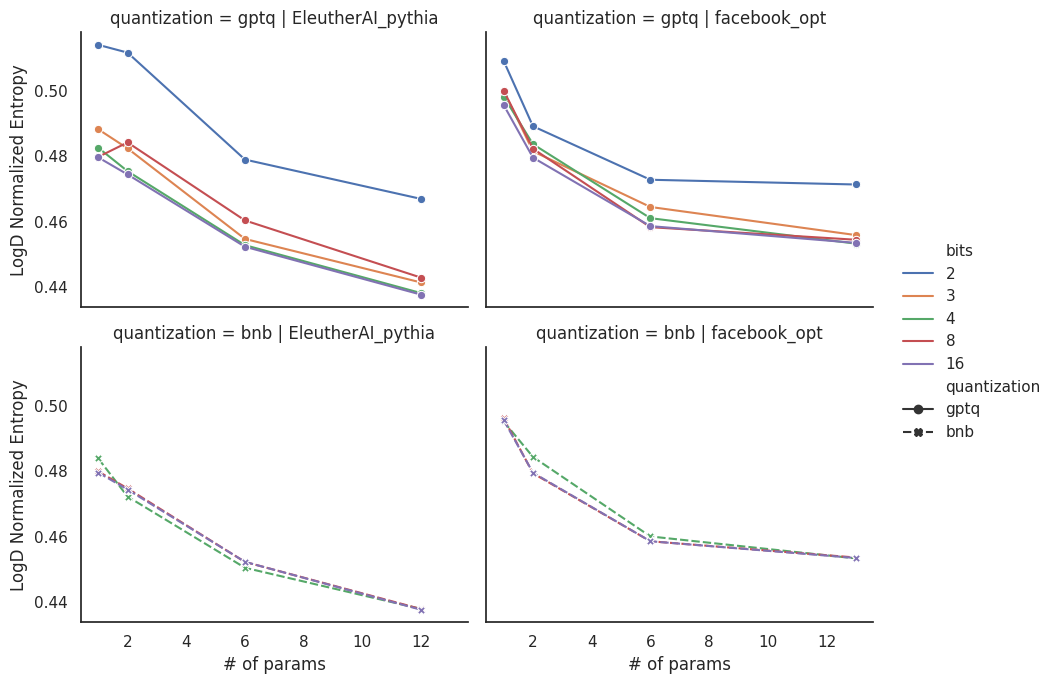

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")

g = sns.relplot(
    data=df,
    x='size',
    y='value',
    hue='bits',
    style='quantization',
    col='model_name',
    row='quantization',
    kind='line',
    markers=True,
    facet_kws={'sharey': True, 'sharex': True},
    height=3.5,
    aspect=1.3,
)

g.set_titles(col_template='{col_name}')
g.set_axis_labels('# of params', 'LogD Normalized Entropy')
g.tight_layout()

plt.show()

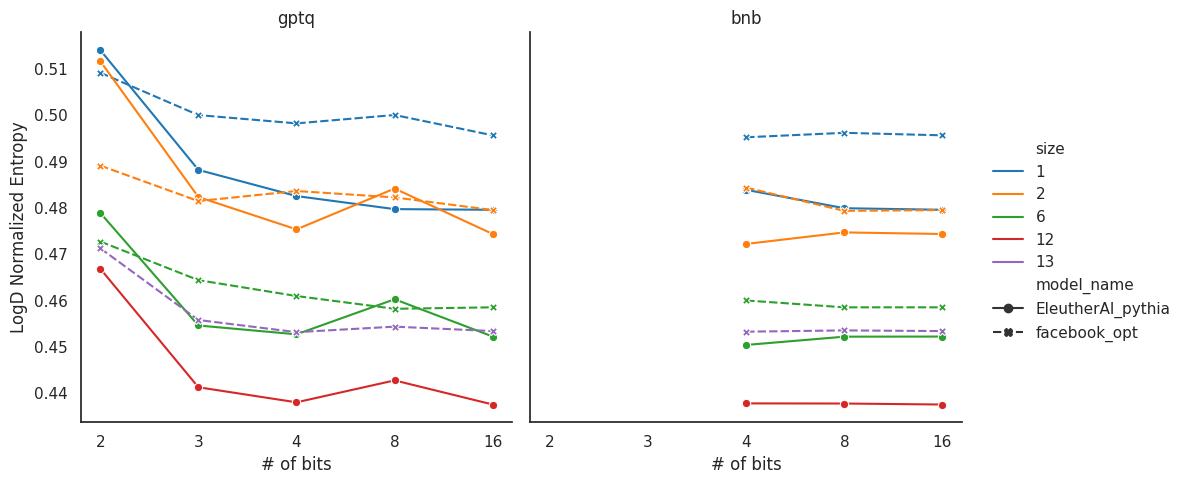

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt


g = sns.relplot(
    data=df,
    x='bits',
    y='value',
    hue='size',
    style='model_name',
    # col='quantization',
    col="quantization", 
    kind='line',
    markers=True,
    palette='tab10',
    facet_kws={'sharey': True, 'sharex': True},
)

g.set_titles(col_template='{col_name}')
g.set_axis_labels('# of bits', 'LogD Normalized Entropy')

g.tight_layout()

plt.show()

In [69]:
import json
from pathlib import Path

lm_eval_dir = Path("../data/lm_eval/")
eval_results = []

# get all files from each subdirectories

for eval_file in lm_eval_dir.rglob("*.json"):
    task = eval_file.parent.parent.name
    model_name = eval_file.parent.name
    quantization = eval_file.stem
    q_framework = quantization.split("-")[0]
    q_bits = re.findall(r'\d+', quantization.split("-")[-1])[0]

    with open(eval_file, "r") as f:
        result = json.load(f)
        eval_results.append({"task":task, "model": model_name, "quantization": q_framework, "bits": q_bits,  "acc": result["results"][task]["acc,none"]})

In [70]:
eval_results

[{'task': 'openbookqa', 'model': 'EleutherAI_pythia-14m', 'quantization': 'float16', 'bits': '16', 'acc': 0.126}, {'task': 'openbookqa', 'model': 'EleutherAI_pythia-14m', 'quantization': 'int4', 'bits': '4', 'acc': 0.136}, {'task': 'openbookqa', 'model': 'EleutherAI_pythia-14m', 'quantization': 'int8', 'bits': '8', 'acc': 0.134}, {'task': 'openbookqa', 'model': 'EleutherAI_pythia-70m', 'quantization': 'float16', 'bits': '16', 'acc': 0.126}, {'task': 'openbookqa', 'model': 'EleutherAI_pythia-70m', 'quantization': 'int4', 'bits': '4', 'acc': 0.128}, {'task': 'openbookqa', 'model': 'EleutherAI_pythia-70m', 'quantization': 'int8', 'bits': '8', 'acc': 0.114}, {'task': 'openbookqa', 'model': 'EleutherAI_pythia-160m', 'quantization': 'float16', 'bits': '16', 'acc': 0.154}, {'task': 'openbookqa', 'model': 'EleutherAI_pythia-160m', 'quantization': 'int4', 'bits': '4', 'acc': 0.154}, {'task': 'openbookqa', 'model': 'EleutherAI_pythia-160m', 'quantization': 'int8', 'bits': '8', 'acc': 0.154}, {'t

In [71]:
import pandas as pd

df = pd.DataFrame(eval_results)
df["size"] = df["model"].apply(lambda x: round(int(re.findall(r'\d+', x.split("-")[-1])[0])))
df["model_name"] = df["model"].apply(lambda x: x.split("-")[0])

non_quantized = df[df["quantization"] == "none"]
for framework in ["gptq", "bnb"]:
    non_quantized_tmp = non_quantized.copy()
    non_quantized_tmp["quantization"] = framework
    df = pd.concat([df, non_quantized_tmp])

df = df[df["quantization"] != "none"]
# df[df["size"] == 12] = 13

In [72]:
df

,task,model,quantization,bits,acc,size,model_name
0,openbookqa,EleutherAI_pythia-14m,float16,16,0.126000,14,EleutherAI_pythia
1,openbookqa,EleutherAI_pythia-14m,int4,4,0.136000,14,EleutherAI_pythia
2,openbookqa,EleutherAI_pythia-14m,int8,8,0.134000,14,EleutherAI_pythia
3,openbookqa,EleutherAI_pythia-70m,float16,16,0.126000,70,EleutherAI_pythia
4,openbookqa,EleutherAI_pythia-70m,int4,4,0.128000,70,EleutherAI_pythia
...,...,...,...,...,...,...,...
199,hellaswag,huggyllama_llama-7b,int4,4,0.565027,7,huggyllama_llama
200,hellaswag,huggyllama_llama-7b,int8,8,0.568512,7,huggyllama_llama
201,hellaswag,huggyllama_llama-13b,float16,16,0.599183,13,huggyllama_llama
202,hellaswag,huggyllama_llama-13b,int4,4,0.591715,13,huggyllama_llama


In [76]:
model_sizes = [
    'EleutherAI_pythia-1.4b', 'EleutherAI_pythia-2.8b', 'EleutherAI_pythia-6.9b', 'EleutherAI_pythia-12b', 
    'facebook_opt-1.3b', 'facebook_opt-2.7b', 'facebook_opt-6.7b', 'facebook_opt-13b',
    'huggyllama_llama-7b', 'huggyllama_llama-13b'
    ]

df = df[df["model"].isin(model_sizes)]
# quantizations = ["gptq-2", "gptq-3", "gptq-4", "gptq-8", "none-float16", "bnb-int4", "bnb-int8"]  #, "quanto-int4", "quanto-int8"]

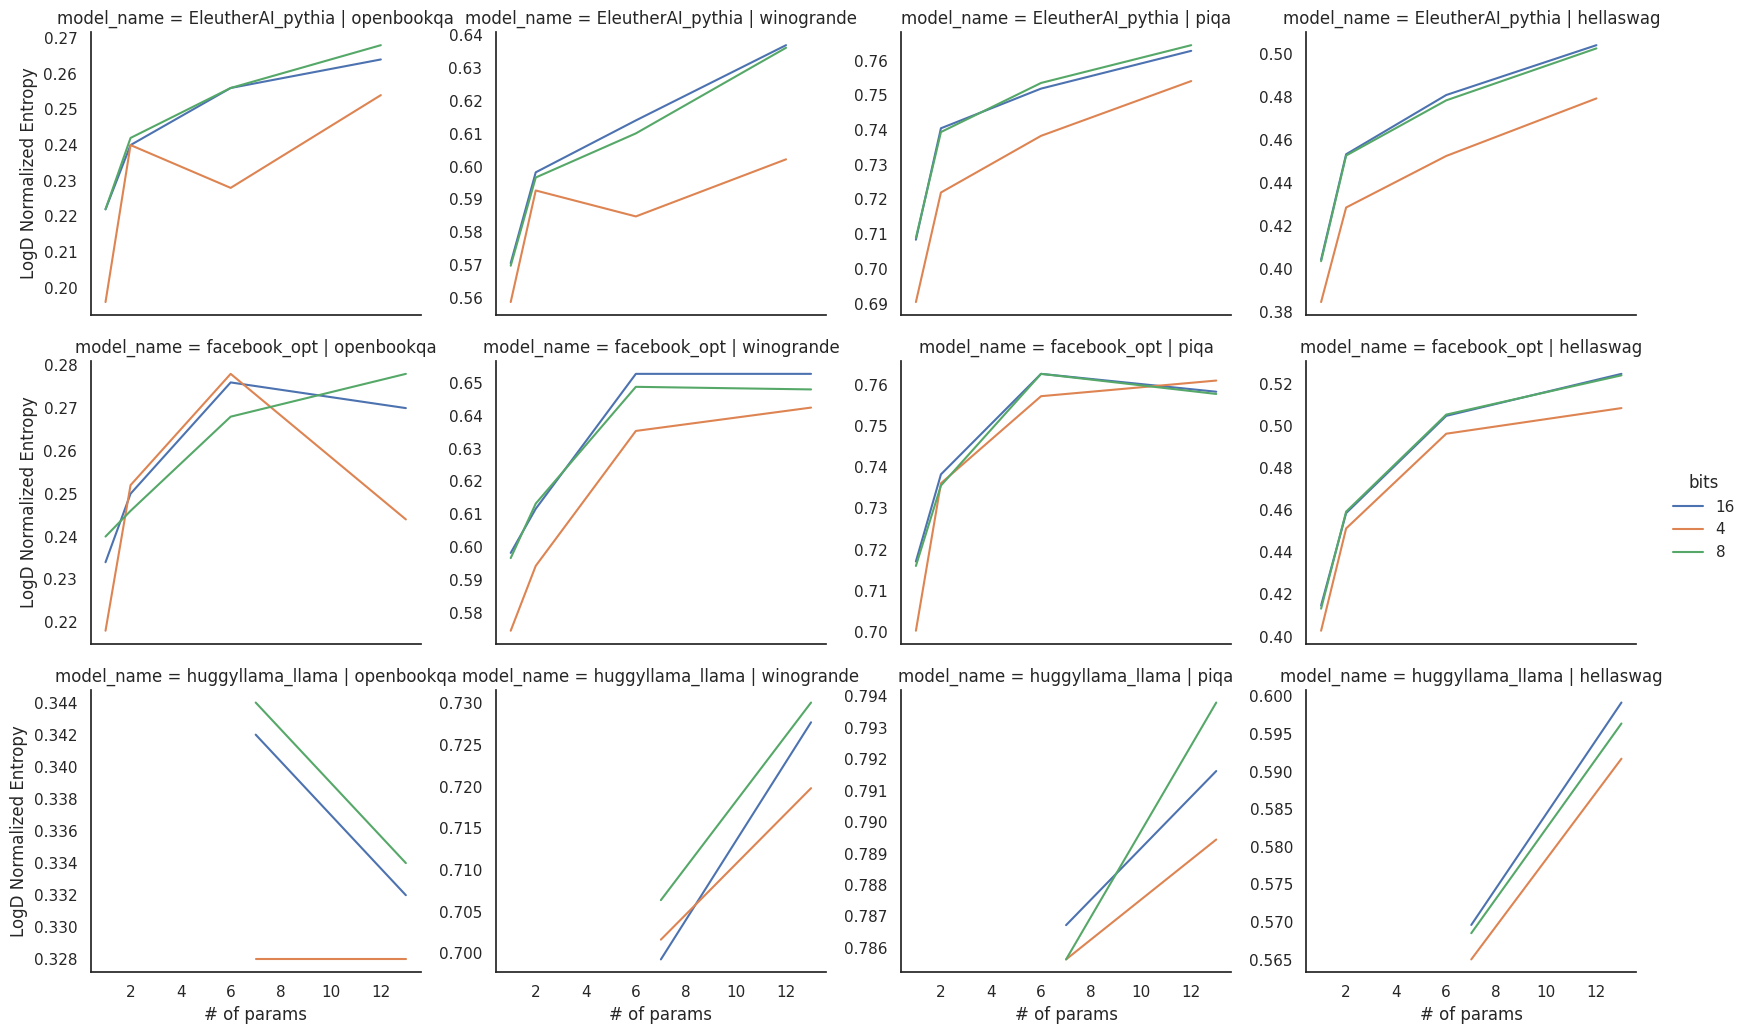

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")

g = sns.relplot(
    data=df,
    x='size',
    y='acc',
    hue='bits',
    # style='quantization',
    col='task',
    row='model_name',
    kind='line',
    markers=True,
    facet_kws={'sharey': False, 'sharex': True},
    height=3.5,
    aspect=1.2,
)

g.set_titles(col_template='{col_name}')
g.set_axis_labels('# of params', 'LogD Normalized Entropy')
g.tight_layout()

plt.show()

# SFT 

In [11]:
import json
import os
from pathlib import Path
from collections import defaultdict

entropies_sft = defaultdict(dict)


entropies_dir = Path(f"../data/entropies_sft/imdb")
for model_entropy_dir in entropies_dir.iterdir():
    print(model_entropy_dir)
    if model_entropy_dir.name.startswith("."):
        continue
    for entropy_file in model_entropy_dir.iterdir():
        with open(entropy_file, "r") as f:
            entropies_sft[model_entropy_dir.name][entropy_file.stem] = json.load(f)

../data/entropies_sft/imdb/.gitignore
../data/entropies_sft/imdb/facebook_opt-125m-bnb-int4-lora
../data/entropies_sft/imdb/facebook_opt-125m-bnb-int8-lora
../data/entropies_sft/imdb/facebook_opt-125m-none-float16-lora
../data/entropies_sft/imdb/facebook_opt-1.3b-bnb-int4-lora
../data/entropies_sft/imdb/facebook_opt-350m-bnb-int8-lora
../data/entropies_sft/imdb/facebook_opt-350m-none-float16-lora
../data/entropies_sft/imdb/facebook_opt-1.3b-bnb-int8-lora
../data/entropies_sft/imdb/facebook_opt-350m-bnb-int4-lora
../data/entropies_sft/imdb/facebook_opt-1.3b-none-float16-lora


In [12]:
import numpy as np
from plots import get_metric

hidden_state = "last"
models = ["facebook_opt-1.3b-bnb-int4-lora", "facebook_opt-1.3b-bnb-int8-lora", "facebook_opt-1.3b-none-float16-lora"]
metrics = ["unnormalized_entropy", "logN_normalized_entropy", "logD_normalized_entropy", "logNlogD_normalized_entropy"]
checkpoints = ['checkpoint-250', 'checkpoint-500', 'checkpoint-750', 'checkpoint-1000', 'checkpoint-1250', 'checkpoint-1500']

mean_metrics_sft = {}

for metric in metrics:
    mean_metrics_sft[metric] = {}
    for model, model_entropies in entropies_sft.items():
        mean_metrics_sft[metric][model] = []
        for checkpoint in checkpoints:
            e = get_metric(model_entropies[checkpoint], metric, hidden_state)
            e = np.mean(e)
            mean_metrics_sft[metric][model].append(e)

KeyError: 'checkpoint-250'

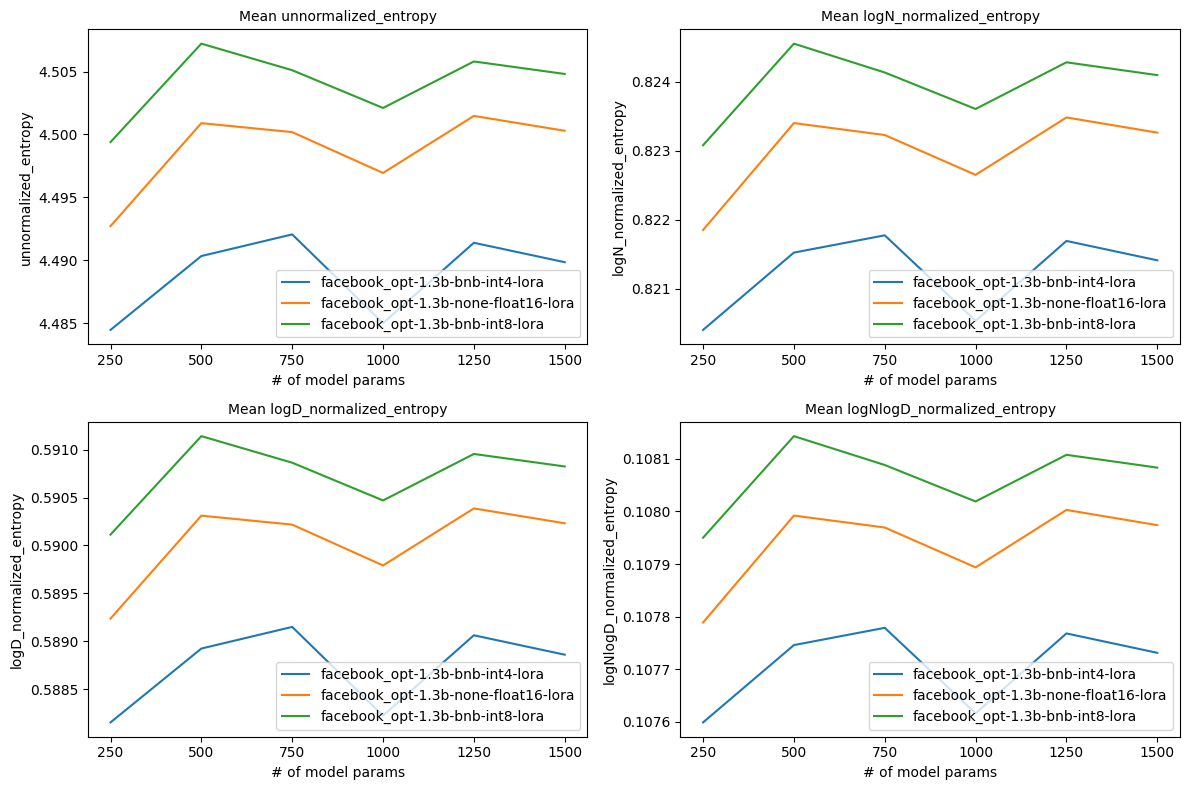

In [ ]:
import matplotlib.pyplot as plt 


fig, axs = plt.subplots(2, 2, figsize=(12, 8))
flatten_axs = axs.flatten()

for i, (metric, model_entropies) in enumerate(mean_metrics_sft.items()):
    for model, checkpoint_entropies in model_entropies.items():
        flatten_axs[i].plot([c.split("-")[-1] for c in checkpoints], checkpoint_entropies, label=model)
        flatten_axs[i].set(xlabel="# of model params", ylabel=metric, title=f"Mean {metric}")
        flatten_axs[i].title.set_fontsize(10)  # Set smaller text size for title
        flatten_axs[i].legend()
    
plt.tight_layout()
plt.show()

In [38]:
import numpy as np
from plots import get_metric

hidden_state = "last"
model_name = "facebook_opt-1.3b-bnb-int4-lora"
metrics = ["unnormalized_entropy", "logN_normalized_entropy", "logD_normalized_entropy", "logNlogD_normalized_entropy"]
checkpoints = ['checkpoint-250', 'checkpoint-500', 'checkpoint-750']

mean_metrics_sft = {}

for metric in metrics:
    mean_metrics_sft[metric] = []
    for checkpoint in checkpoints:
        e = get_metric(entropies_sft[model_name][checkpoint], metric, hidden_state)
        e = np.mean(e)
        mean_metrics_sft[metric].append(e)

In [37]:
for i, (metric, model_entropies) in enumerate(mean_metrics_sft.items()):
    for model, checkpoint_entropies in model_entropies.items():
        break

AttributeError: 'list' object has no attribute 'items'

In [39]:
model_entropies

[4.4844604463815685, 4.490332155561447, 4.492051692402363]

In [27]:
checkpoint_entropies

[0.10759917426325515,
 0.10774606511309176,
 0.10761645484558671,
 0.1077788761836588,
 0.10776821288475195,
 0.1077313898361746]

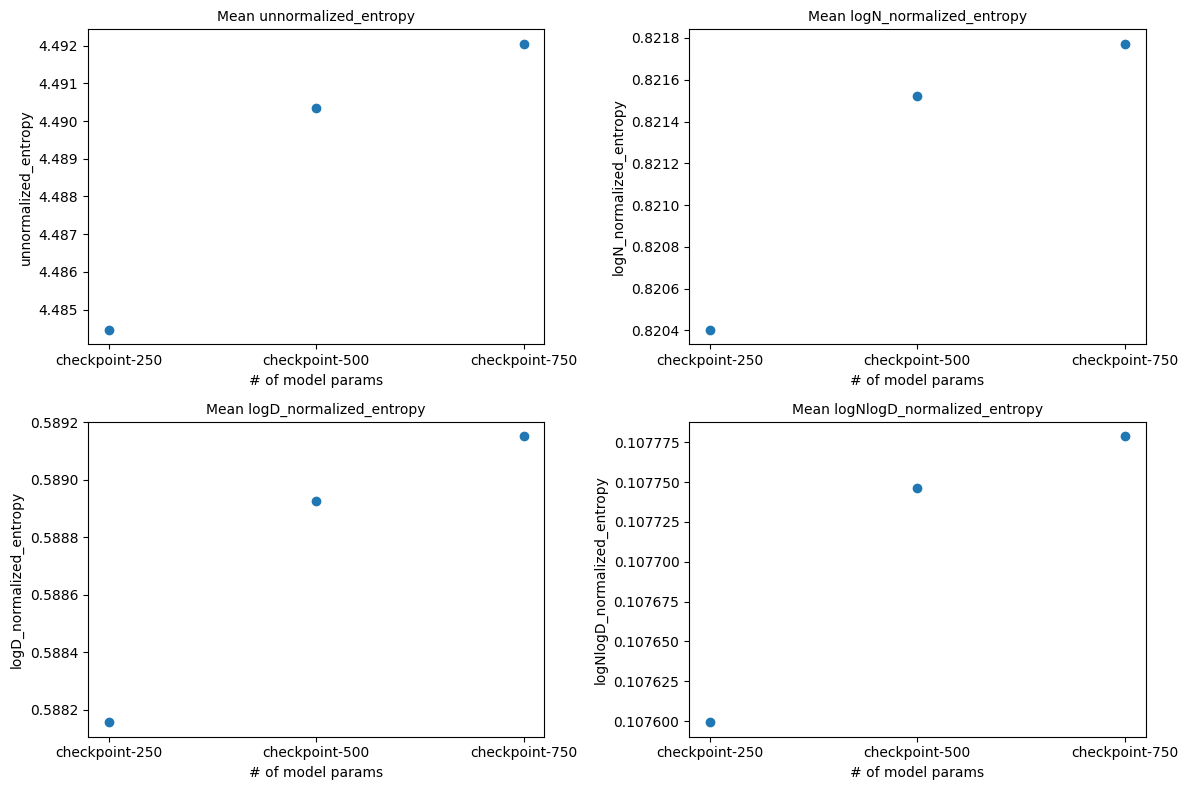

In [32]:
import matplotlib.pyplot as plt 


fig, axs = plt.subplots(2, 2, figsize=(12, 8))
flatten_axs = axs.flatten()

# for i, (metric, model_entropies) in enumerate(mean_metrics_sft.items()):
#     for model, checkpoint_entropies in model_entropies.items():
#         flatten_axs[i].plot([c.split("-")[-1] for c in checkpoints], checkpoint_entropies, label=model)
#         flatten_axs[i].set(xlabel="# of model params", ylabel=metric, title=f"Mean {metric}")
#         flatten_axs[i].title.set_fontsize(10)  # Set smaller text size for title
#         flatten_axs[i].legend()


for i, metric in enumerate(metrics):
    flatten_axs[i].scatter(checkpoints, mean_metrics_sft[metric])
    flatten_axs[i].set(xlabel="# of model params", ylabel=metric, title=f"Mean {metric}")
    flatten_axs[i].title.set_fontsize(10)  # Set smaller text size for title
    
plt.tight_layout()
plt.show()